In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install openpyxl

In [8]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Dataset/TopicExtraction/Pubmed5k.xlsx')

In [9]:
df.head()

,ArticleID,Title,Abstract
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...


In [10]:
df["content"] = df["Title"] + ', ' + df["Abstract"]

In [11]:
import re

def clean_text(line):
    line = re.sub(r'\s+', ' ', line.lower())
    line = re.sub(r"\'", "", line)
    line = re.sub('[,\.!?]', '', line)
    tokens = [re.sub('[^a-zA-Z0-9]+', '', t) for t in line.split()]
    tokens = [t for t in tokens if not t.isdigit()]
    tokens = [t for t in tokens if len(t)>3]
    cleaned_line = " ".join(tokens)
    return cleaned_line.strip()

In [12]:
df['content'] = df['content'].apply(lambda x: clean_text(x))
df['content'].head()

0    stable coordination variability overground wal...
1    weak strength increases dynamic knee valgus si...
2    current future projections amyotrophic lateral...
3    disparities between asian nonasian thrombolyze...
4    maternal factors predicting loss followup from...
Name: content, dtype: object

In [13]:
from pprint import pprint

data = df.content.values.tolist()

pprint(data[:1])

['stable coordination variability overground walking running preferred fixed '
 'speeds coordination variability commonly analyzed understand dynamical '
 'qualities human locomotion purpose this study develop guidelines number '
 'trials required inform calculation stable mean lower limb during overground '
 'locomotion threedimensional lower limb kinematics were captured recreational '
 'runners performing trials each preferred fixed speed walking running stance '
 'phase calculated segment joint couplings using modified vector coding '
 'technique number trials required achieve mean within strides average '
 'determined each coupling individual statistical outputs mode walking running '
 'speed preferred fixed were compared when informed differing numbers trials '
 'minimum trials were required stable mean stance phase with fewer than trials '
 'underestimated oversight significant differences between mode speed future '
 'overground locomotion research healthy populations using vec

In [14]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['stable', 'coordination', 'variability', 'overground', 'walking', 'running', 'preferred', 'fixed', 'speeds', 'coordination', 'variability', 'commonly', 'analyzed', 'understand', 'dynamical', 'qualities', 'human', 'locomotion', 'purpose', 'this', 'study', 'develop', 'guidelines', 'number', 'trials', 'required', 'inform', 'calculation', 'stable', 'mean', 'lower', 'limb', 'during', 'overground', 'locomotion', 'lower', 'limb', 'kinematics', 'were', 'captured', 'recreational', 'runners', 'performing', 'trials', 'each', 'preferred', 'fixed', 'speed', 'walking', 'running', 'stance', 'phase', 'calculated', 'segment', 'joint', 'couplings', 'using', 'modified', 'vector', 'coding', 'technique', 'number', 'trials', 'required', 'achieve', 'mean', 'within', 'strides', 'average', 'determined', 'each', 'coupling', 'individual', 'statistical', 'outputs', 'mode', 'walking', 'running', 'speed', 'preferred', 'fixed', 'were', 'compared', 'when', 'informed', 'differing', 'numbers', 'trials', 'minimum', 't

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

def build_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [17]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)#
trigram_mod = gensim.models.phrases.Phraser(trigram)

def build_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [18]:
def lemmatization(docs, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    for i in range(len(docs)):
        docs[i] = nlp(" ".join(docs[i])) 
        docs[i] = [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in docs[i] if token.pos_ in allowed_postags]
    return docs

In [19]:
import spacy

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = build_bigrams(data_words_nostops)
#data_words_trigrams = build_trigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['stable', 'coordination', 'variability', 'overground', 'walk', 'run', 'preferred', 'fix', 'speed', 'coordination', 'variability', 'commonly', 'analyze', 'understand', 'dynamical', 'quality', 'locomotion', 'purpose', 'study', 'develop', 'guideline', 'number', 'trial', 'require', 'inform', 'calculation', 'stable', 'overground', 'kinematic', 'capture', 'recreational', 'runner', 'perform', 'trial', 'prefer', 'fix', 'speed', 'walk', 'run', 'stance', 'phase', 'calculate', 'segment', 'joint', 'coupling', 'use', 'modify', 'vector', 'coding', 'technique', 'number', 'trial', 'require', 'achieve', 'mean', 'stride', 'average', 'determine', 'couple', 'individual', 'statistical', 'output', 'mode', 'walk', 'running_spee', 'prefer', 'fix', 'compare', 'inform', 'differ', 'number', 'trial', 'minimum', 'trial', 'require', 'stable', 'mean', 'stance', 'phase', 'few', 'trial', 'underestimate', 'oversight', 'significant', 'difference', 'mode', 'speed', 'locomotion', 'research', 'healthy', 'population', 'us

In [20]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_lemmatized, test_size=0.2, shuffle=False)

del data_lemmatized

In [21]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(train_data)
train_corpus = [id2word.doc2bow(text) for text in train_data]
print(train_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 2), (33, 2), (34, 1), (35, 1), (36, 4), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 2), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 3), (58, 3), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 8), (66, 1), (67, 1), (68, 2), (69, 2), (70, 2), (71, 3)]]


In [22]:
def build_LdaMulticore(corpus, id2word):
    return gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=10, 
                                      random_state=2,
                                      chunksize=128,
                                      passes=10,
                                      per_word_topics=True)

In [23]:
lda_model = build_LdaMulticore(train_corpus, id2word)
doc_lda = lda_model[train_corpus]

In [24]:
from gensim.models import CoherenceModel

def compute_Coherence_score(model, data_lemmatized, id2word):
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()


print('Coherence Score: ', compute_Coherence_score(lda_model, train_data, id2word))

Coherence Score:  0.3786531183118435


In [25]:
def compute_coherence_values(corpus, dictionary, text_data, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text_data, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [26]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}
topics_range = range(5, 11, 1)
alpha = list(np.arange(0.5, 1, 0.1))
alpha.append('symmetric')
alpha.append('asymmetric')

beta = list(np.arange(0.5, 1, 0.1))
beta.append('symmetric')

num_of_docs = len(train_corpus)
corpus_sets = [gensim.utils.ClippedCorpus(train_corpus, int(num_of_docs*0.8)), train_corpus]
corpus_title = ['80% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

pbar = tqdm.tqdm(total=len(corpus_sets)*len(topics_range)*len(alpha)*len(beta))

# for i in range(len(corpus_sets)):
#     for k in topics_range:
#         for a in alpha:
#             for b in beta:
#                 cv = compute_coherence_values(corpus=corpus_sets[i], 
#                                               dictionary=id2word, 
#                                               text_data=train_data,
#                                               k=k, a=a, b=b)
#                 model_results['Validation_Set'].append(corpus_title[i])
#                 model_results['Topics'].append(k)
#                 model_results['Alpha'].append(a)
#                 model_results['Beta'].append(b)
#                 model_results['Coherence'].append(cv)                
#                 pbar.update(1)                
# pbar.close()

  0%|          | 0/504 [00:00<?, ?it/s]

In [27]:
res_df = pd.DataFrame(model_results)
res_df

In [ ]:
res_df.to_csv('lda_tuning_results.csv', index=False)

In [28]:
lda_model = gensim.models.LdaMulticore(corpus=train_corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=0.01,
                                       eta=0.9)

In [45]:
!pip install pyldavis

In [46]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, train_corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.182976  0.063745       1        1  54.481406
3      0.094250  0.020224       2        1  26.635443
2      0.028235 -0.145855       3        1  17.899794
0     -0.152450  0.031393       4        1   0.547589
1     -0.153011  0.030494       5        1   0.435768, topic_info=                  Term         Freq        Total Category  logprob  loglift
359               cell  1151.000000  1151.000000  Default  30.0000  30.0000
165            patient  3255.000000  3255.000000  Default  29.0000  29.0000
1874            specie  1123.000000  1123.000000  Default  28.0000  28.0000
633            protein   683.000000   683.000000  Default  27.0000  27.0000
672               gene   643.000000   643.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
23143      palaearctic     0.422125     7.383383   Topic5  -8.3341   2.5741
6640            revise     0.505785    45.238547   Topic5  -8.1533   0.9422
27125  eating_behavior     0.459568    18.622478   Topic5  -8.2491   1.7340
2460         designate     0.429914    20.198089   Topic5  -8.3158   1.5861
23096     tischeriidae     0.412267     6.624711   Topic5  -8.3577   2.6589

[334 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2557      1  0.017169    activate
2557      2  0.025754    activate
2557      3  0.952890    activate
3539      1  0.007357  activation
3539      2  0.044142  activation
...     ...       ...         ...
305       2  0.001575       woman
305       3  0.001575       woman
186       1  0.964781        year
186       2  0.034181        year
186       3  0.001103        year

[908 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])

In [123]:
def get_docs_topic_score(corpus):
  topic_prop_list = list(lda_model.get_document_topics(corpus))
  n_topics = max(topic_prop_list, key=lambda item: len(item))

  lda_output = []
  for t in topic_prop_list:
    tmp_prop = [0 for _ in range(lda_model.num_topics)]
    for j in t:
      tmp_prop[j[0]] = j[1]
    lda_output.append(tmp_prop)

  return np.array(lda_output)

In [124]:
lda_output = get_docs_topic_score(train_corpus)

In [83]:
topicnames = ["Topic" + str(i) for i in range(lda_model.num_topics)] 
docnames = ["Doc" + str(i) for i in range(len(train_data))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.460000,0.540000,4
Doc1,0.090000,0.000000,0.000000,0.000000,0.910000,4
Doc2,0.000000,0.000000,0.000000,0.000000,1.000000,4
Doc3,0.000000,0.000000,0.000000,0.000000,1.000000,4
Doc4,0.000000,0.000000,0.000000,0.000000,1.000000,4
Doc5,0.000000,0.000000,0.000000,0.000000,1.000000,4
Doc6,0.000000,0.000000,0.430000,0.170000,0.410000,2
Doc7,0.000000,0.000000,0.000000,0.000000,1.000000,4
Doc8,0.000000,0.000000,0.110000,0.000000,0.890000,4
Doc9,0.000000,0.000000,0.340000,0.140000,0.510000,4


In [84]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,2056
1,3,1170
2,2,758
3,1,10
4,0,5


In [143]:
def predict_topic(text, nlp=nlp, n_topics=3): 
    tmp_text = list(sent_to_words(text))
    tmp_text = [" ".join(t) for t in tmp_text]
    tmp_text = lemmatization(tmp_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    corpus = [id2word.doc2bow(text) for text in tmp_text]
    topic_probability_scores = get_docs_topic_score(corpus)
    top_topic = np.argmax(topic_probability_scores)
    top_n_topic = (-topic_probability_scores).argsort(axis=1)[:n_topics][0]
    sorted_topic_probability_scores = topic_probability_scores.copy()
    sorted_topic_probability_scores.sort(axis=1)
    sorted_topic_probability_scores = sorted_topic_probability_scores[0][::-1]
    topic_keywords = lda_model.get_topic_terms(top_topic, topn=10)
    
    return top_topic, top_n_topic, sorted_topic_probability_scores, topic_probability_scores, topic_keywords

text = [test_data[0]]
top_topic, top_n_topic, sorted_topic, _, _ = predict_topic(text = text)
print(top_topic)
print(top_n_topic)
print(sorted_topic)


2
[2 1 0 3 4]
[0.4982675  0.26124477 0.24032114 0.         0.        ]


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [128]:

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

svd_model = TruncatedSVD(n_components=3) 
lda_output_svd = svd_model.fit_transform(lda_output)
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
z = lda_output_svd[:, 2]

print("Component's weights: \n", np.round(svd_model.components_, 2))

print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.01  0.    0.13  0.17  0.98]
 [ 0.    0.01  0.22  0.96 -0.2 ]
 [-0.   -0.01  0.97 -0.24 -0.09]]
Perc of Variance Explained: 
 [0.29 0.43 0.27]


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

No handles with labels found to put in legend.


Text(0.5, 0.92, 'Segregation of Topic Clusters')

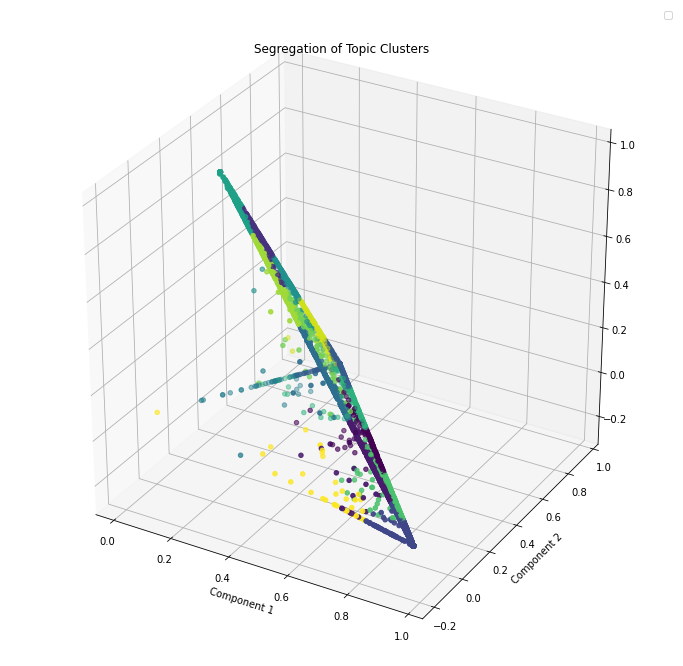

In [130]:
from matplotlib import pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=clusters)
ax.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("Segregation of Topic Clusters")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 0, 'Component 2')

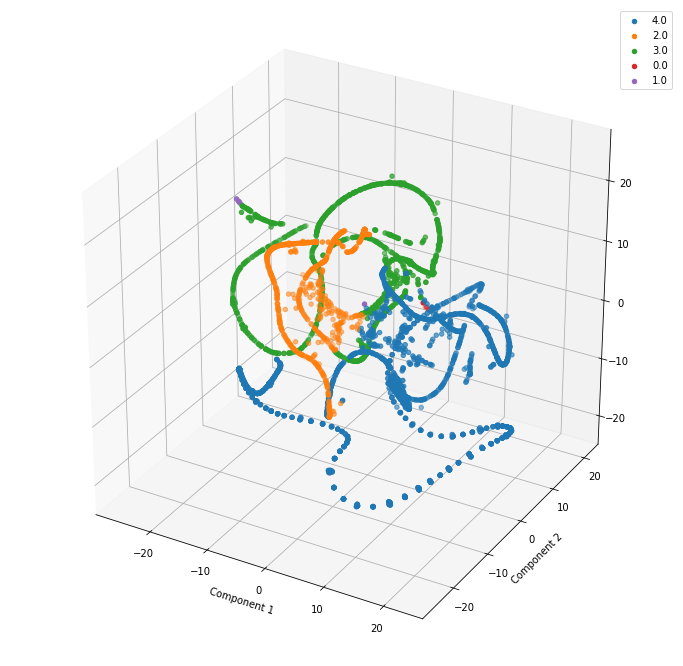

In [131]:
from sklearn.manifold import TSNE
import pylab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(lda_output)

#x, y, z = list(zip(*projections))

vis_df = projections.copy()
topics = np.argmax(lda_output, axis=1).reshape(-1,1)
vis_df = np.hstack((vis_df, topics))
vis_df = pd.DataFrame(data=vis_df, columns=['x', 'y', 'z', 
                                            'topic'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for t in vis_df.topic.unique():
    ax.scatter(vis_df.x[vis_df.topic==t], 
               vis_df.y[vis_df.topic==t], 
               vis_df.z[vis_df.topic==t],
               label=t)
    
ax.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [140]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    top_topic, top_n_topic, sorted_topic_probability_scores, topic_probability_scores, _ = predict_topic(text)
    dists = euclidean_distances(topic_probability_scores.reshape(1, -1), doc_topic_probs)    
    doc_ids = np.argsort(dists[0])
    doc_ids = doc_ids[:top_n]
    if verbose:        
        print("Top Topic : ", top_topic)
        print("Top N Topic: ", top_n_topic)
        print("Topic Prob Sorted Scores of text: ", np.round(sorted_topic_probability_scores, 2))
        print("Most Similar Doc's Probs:  \n", np.round(doc_topic_probs[doc_ids], 2))
    return doc_ids, np.take(documents, doc_ids)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [141]:
text = [test_data[0]]

doc_ids, docs = similar_documents(text=text, doc_topic_probs=lda_output, documents = data, top_n=3, verbose=True)
print(docs)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


Top Topic :  2
Top N Topic:  [2 1 0 3 4]
Topic Prob Sorted Scores of text:  [0.5  0.27 0.24 0.   0.  ]
Most Similar Doc's Probs:  
 [[0.11 0.   0.58 0.   0.3 ]
 [0.04 0.   0.67 0.1  0.19]
 [0.16 0.   0.4  0.16 0.28]]
['ocular involvement hereditary transthyretin amyloidosis case series describing novel potential biomarkers hereditary transthyretin amyloidosis hattr rare disease caused point mutation transthyretin gene inherited autosomal dominant fashion plasma protein that functions carrier thyroxine retinol vitamin ophthalmological manifestations both hepatic ocular production mutated this case series report ocular manifestations hattr eighteen eyes nine consecutive patients corneal nerve abnormalities well morphological functional changes retina were investigated study singlecenter retrospective observational clinical case series patients corneal confocal microscopy multimodal imaging retina including fundus photography optical coherence tomography well cone electroretinography were